In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from models import RVAEModel, ClassModel
from data_utils import DataFactory
from fastdtw import fastdtw
import fancyimpute
tf.enable_eager_execution()
%matplotlib inline

/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

/home/malzantot/Nesl/bio_gan/icu_dataset.py:12: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/malzantot/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/malzantot/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/malzantot/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/malzantot/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/malzantot/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_lo

In [2]:
CHECKPOINT_DIR = './save/ecg_physgan/07_27_21_11'
AUX_CHECKPOINT_DIR = './save/ecg_long_lstm/07_30_21_11'


In [3]:
ecg_train, ecg_test, metadata = DataFactory.create_dataset('ecg_long')

['1 NSR', '4 AFIB']
['1 NSR', '4 AFIB']
(array([0, 1], dtype=int32), array([211, 102]))
['1 NSR', '4 AFIB']
['1 NSR', '4 AFIB']
(array([0, 1], dtype=int32), array([72, 33]))


In [4]:

model = RVAEModel(enc_rnn_units=128,z_dim=8,dec_rnn_units=128,num_feats=metadata.num_feats,num_labels=metadata.num_labels)

aux_model = ClassModel(num_feats=1,num_labels=2)

W0730 21:53:18.705860 140276651427648 deprecation_wrapper.py:119] From /home/malzantot/Nesl/bio_gan/models.py:103: The name tf.keras.layers.CuDNNGRU is deprecated. Please use tf.compat.v1.keras.layers.CuDNNGRU instead.



In [5]:
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))

aux_checkpoint = tf.train.Checkpoint(model=aux_model)
aux_checkpoint.restore(tf.train.latest_checkpoint(AUX_CHECKPOINT_DIR))

In [6]:
def evaluate_accuracy(aux_model, data_x, data_y):
    preds = tf.arg_max(aux_model(data_x),dimension=1)
    accuracy_metric = tf.keras.metrics.Accuracy()
    accuracy_metric.update_state(data_y, preds)
    return accuracy_metric.result().numpy()

In [7]:
test_x, test_y = next(iter(ecg_test.shuffle(1000).batch(200)))
evaluate_accuracy(aux_model, test_x, test_y)

W0730 21:53:20.483527 140276651427648 deprecation.py:323] From <ipython-input-6-fe888aaa0516>:2: arg_max (from tensorflow.python.ops.gen_math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.math.argmax` instead


0.9904762

### Evaluate

In [8]:
def get_testset(test_dataset, test_size=200, mask_type='random'):
    test_x, test_y = next(iter(test_dataset.shuffle(1000).batch(test_size)))
    test_masks = []
    test_originals = []
    test_inputs = []
    test_labels = []
    mask_len = 24
    for i in range(test_x.shape[0]):
        test_sample = test_x[i].numpy()
        if mask_type=='random':
            mask = (np.random.uniform(size=test_sample.shape) < 0.5).astype(np.float32)
        elif mask_type == 'segment':
            rand_pos = int(np.random.uniform(low=0, high=int(test_x[i].shape[0])-mask_len))
            mask = np.ones_like(test_sample)
            drop_range = np.arange(rand_pos, rand_pos+mask_len)
            mask[drop_range,:]= np.nan
        else:
            raise ValueError('Unsupported mask type')
        test_masks.append(np.expand_dims(mask,0))
        test_sample_masked = np.multiply(mask, test_sample)
        test_inputs.append(test_sample_masked)
        test_originals.append(test_sample)
        test_labels .append(test_y[i:i+1])

    test_labels = np.array(test_labels).ravel()
    test_originals = np.array(test_originals)
    test_masks = np.array(test_masks)
    test_inputs = np.array(test_inputs)
    return (test_originals, test_labels, test_masks, test_inputs)

### Prepare data

In [9]:
train_x, train_y = next(iter(ecg_train.shuffle(1000).batch(200)))
train_x = train_x.numpy()
train_y = train_y.numpy()

In [10]:
mask_type = 'segment'

test_x, test_y, test_masks, test_masked = get_testset(ecg_test, mask_type=mask_type)

accuracy_complete = evaluate_accuracy(aux_model, test_x, test_y)
print("Accuracy of complete data = {:.2f}".format(accuracy_complete))
accuracy_incomplete = evaluate_accuracy(aux_model, test_masked, test_y)
print('Accuracy of incomplete data = {:.2f}'.format(accuracy_incomplete))

Accuracy of complete data = 0.99
Accuracy of incomplete data = 0.69


### Imputation code

In [11]:
def impute_knn(train_x, train_y, test_x, test_y):
    x_incomplete = np.r_[ test_x, train_x]
    y_incomplete = np.r_[ test_y, train_y]
    knn_impute = fancyimpute.KNN(k=10, verbose=True)
    x_knn = knn_impute.fit_transform(x_incomplete[:,:,0],y=y_incomplete)
    return x_knn[:test_x.shape[0],:,np.newaxis]

In [12]:
def impute_physgan(test_x, test_y, test_masks):
    impute_outputs = []
    for i, (x_mask, x_in, x_label) in enumerate(zip(test_masks, test_x, test_y)):
        x_in_tf = tf.convert_to_tensor([np.nan_to_num(x_in)])
        x_label = x_label.reshape((-1,))
        x_mask = np.nan_to_num(x_mask)
        impute_result = model.impute(x_in_tf, x_label, x_mask).numpy()
        impute_outputs.append(impute_result[0])
    return np.array(impute_outputs)

In [13]:
physgan_complete = impute_physgan(test_masked, test_y, test_masks)

W0730 21:53:20.707301 140276651427648 deprecation_wrapper.py:119] From /home/malzantot/Nesl/bio_gan/models.py:112: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [14]:
knn_complete = impute_knn(train_x, train_y, test_masked, test_y)

Imputing row 1/305 with 24 missing, elapsed time: 0.032
Imputing row 101/305 with 24 missing, elapsed time: 0.062
Imputing row 201/305 with 0 missing, elapsed time: 0.063
Imputing row 301/305 with 0 missing, elapsed time: 0.064


### Evaluation code

In [15]:
def compute_mae(orig, imputed, mask):
    mae = np.sum(np.abs(orig-imputed)) / np.sum(np.nan_to_num(mask)==0)
    return mae


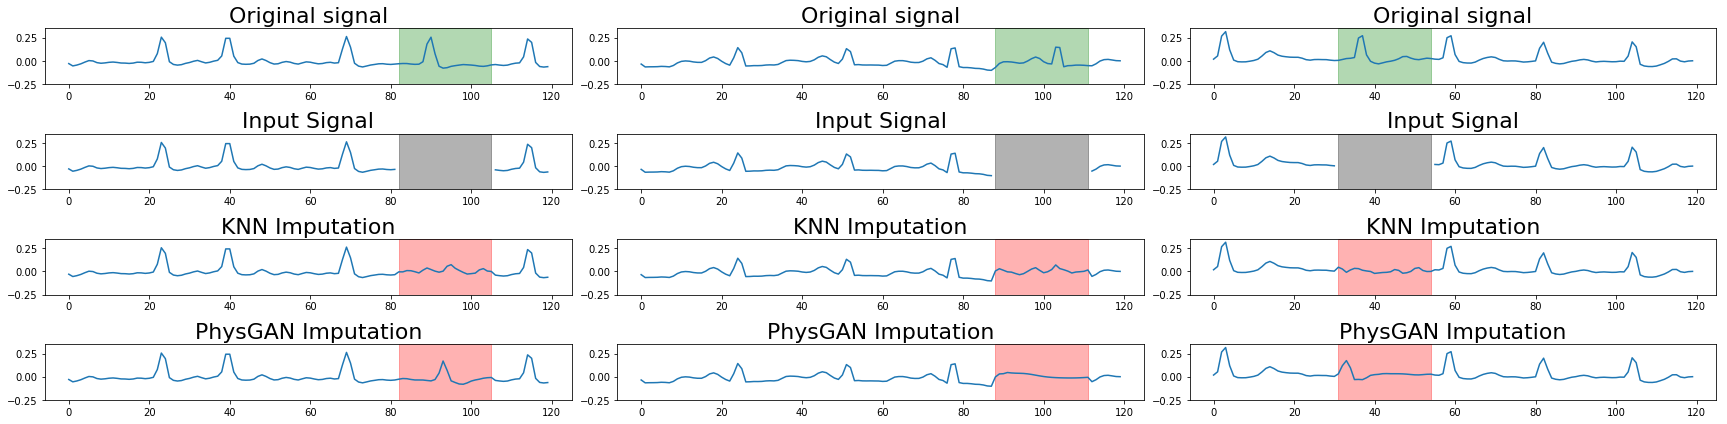

In [30]:
num_examples = 3
fig, axes = plt.subplots(4, num_examples, figsize=(24,6))
test_idxs = np.random.choice(len(test_x),size=3,replace=False)
for idx in range(num_examples):
    test_idx = test_idxs[idx]
    test_mask = test_masks[test_idx]
    test_x_masked = test_masked[test_idx]
    test_orig = test_x[test_idx]
    #test_result = impute_outputs[test_idx]
    
    drop_range = np.where(test_mask[0,:,0] != 1)
    axes[0][idx].plot(test_orig[:,0])
    axes[0][idx].set_title('Original signal', fontsize=22)
    axes[0][idx].axvspan(np.min(drop_range), np.max(drop_range), color='green', alpha=0.3)
    axes[0][idx].set_ylim(-0.25, 0.35)

    axes[1][idx].set_title('Input Signal',fontsize=22)
    axes[1][idx].plot( test_x_masked[:,0])
    axes[1][idx].axvspan(np.min(drop_range), np.max(drop_range), color='black', alpha=0.3)
    axes[1][idx].set_ylim(-0.25, 0.35)

    
    axes[2][idx].plot(knn_complete[test_idx,:,0])
    axes[2][idx].set_title('KNN Imputation', fontsize=22)
    axes[2][idx].axvspan(np.min(drop_range), np.max(drop_range), color='red', alpha=0.3)
    axes[2][idx].set_ylim(-0.25, 0.35)
    
    axes[3][idx].plot(physgan_complete[test_idx,:,0])
    axes[3][idx].set_title('PhysGAN Imputation', fontsize=22)
    axes[3][idx].axvspan(np.min(drop_range), np.max(drop_range), color='red', alpha=0.3)
    axes[3][idx].set_ylim(-0.25, 0.35)

plt.tight_layout()

plt.savefig('imputation_result_new.png')

### MAE metric

In [17]:
def evaluate_mae(data_orig, data_completed, masks):
    mae_list = []
    for x, x_hat, m in zip(data_orig, data_completed, masks):
        mae_list.append(compute_mae(x, x_hat, m))
    return np.mean(mae_list)

In [18]:
compute_mae(test_x, knn_complete, test_masks)

0.049265519399491565

In [19]:
compute_mae(test_x, physgan_complete, test_masks)

0.06815831017872644

## Semantic metric

In [20]:
def evaluate_semantic(aux_model, data_orig, data_y, data_masked, data_completed):
    accuracy_orig = evaluate_accuracy(aux_model, data_orig, data_y)
    accuracy_masked = evaluate_accuracy(aux_model, data_masked, data_y)
    accuracy_completed = evaluate_accuracy(aux_model, data_completed, data_y)
    
    score = (accuracy_completed - accuracy_masked) /( accuracy_orig - accuracy_completed)
    print('orig: {:.2f}, masked: {:.2f}, completed: {:.2f}'.format(accuracy_orig, accuracy_masked, accuracy_completed))
    return score
    

In [21]:
evaluate_semantic(aux_model, test_x, test_y, test_masked, knn_complete)

orig: 0.99, masked: 0.69, completed: 0.97


15.0

In [22]:
evaluate_semantic(aux_model, test_x, test_y, test_masked, physgan_complete)

orig: 0.99, masked: 0.69, completed: 0.98


31.0